In [72]:
import pandas as pd
import numpy as np
import os
import larch
import caliperpy
from larch.roles import P,X
pd.set_option('display.max_columns', None)

In [73]:
# Open all files from appropriate folders
surveyFile = "C:\\projects\\Oahu\\repo_new_model\\docs\\data\\_private\\vis_survey\\output\\vis_trips.csv"
# hhFile = "C:\\projects\\Oahu\\repo_new_model\\scenarios\\base_2022\\Output\\Population\\Households.bin"
tazFile = "C:\\projects\\Oahu\\repo_new_model\\master\\tazs\\master_tazs.bin"
seFile = "C:\\projects\\Oahu\\repo_new_model\\scenarios\\base_2022\\Output\\sedata\\scenario_se.bin"
# accFile = os.path.join(path, 'TAZAccessibilities.bin')

skim_path = "C:\\projects\\Oahu\\repo_new_model\\docs\\data\\input\\skims\\"
autoSkim = skim_path + "Highway_AM.omx"
ptwalkSkim = skim_path + 'Walk_to_Bus.omx'
izMatrix = skim_path + "IntraZonal.omx"
purpose = 'HBRec'
logsum_personal = "C:\\projects\\Oahu\\repo_new_model\\docs\\data\\input\\logsums\\ls_" + purpose + "_personal_AM.omx"
logsum_business = "C:\\projects\\Oahu\\repo_new_model\\docs\\data\\input\\logsums\\ls_" + purpose + "_business_AM.omx"


In [74]:
# Import both the TAZ and Survey Files into dataframes
surveyDF = pd.read_csv(surveyFile)
dk = caliperpy.TransCAD.connect()
# surveyDF = dk.GetDataFrameFromBin(surveyFile)
# hhDF = dk.GetDataFrameFromBin(hhFile)
tazDF = dk.GetDataFrameFromBin(tazFile)
seDF = dk.GetDataFrameFromBin(seFile)
# accDF = dk.GetDataFrameFromBin(accFile)
caliperpy.TransCAD.disconnect()

Connecting to TransCAD...
Disconnected from TransCAD!


True

In [75]:
# Join se data to the TAZ file
tazDF = pd.merge(tazDF, seDF, left_on='TAZID', right_on='TAZ')
tazDF['Cluster'] = tazDF['District7']
# For the vis model, collapse clusters 1 and 3
tazDF['Cluster'] = tazDF['Cluster'].replace(3, 1)
tazDF['VisArrivalsWork'].fillna(0, inplace=True)
tazDF['VisArrivalsRec'].fillna(0, inplace=True)

In [76]:

# Add the origin cluster field, which is needed later
surveyDF = surveyDF.merge(tazDF[['TAZID', 'Cluster']], left_on='o_taz', right_on = 'TAZID')
surveyDF = surveyDF.rename(columns={'Cluster': 'o_Cluster'})

# Add sequential EstDataID to the survey table
surveyDF['EstDataID'] = np.arange(len(surveyDF)) + 1
surveyDF.head()

,SAMPN,weight,visitor_type,party,deptime,arrtime,mode,o_purp,d_purp,o_taz,d_taz,o_ptype,d_ptype,pa_flag,p_taz,a_taz,iz_flag,p_purp,a_purp,trip_purp,auto_time,auto_distance,bike_time,bike_distance,walk_time,walk_distance,bus_gen_cost,bus_fare,bus_ivtt,bus_init_wait,bus_xfer_wait,bus_init_pen_time,bus_xfer_pen_time,bus_xfer_walk_time,bus_access_walk_time,bus_egress_walk_time,bus_dwell_time,bus_total_time,bus_num_xfers,bus_iv_distance,bus_length,bus_walk_time,TAZID,o_Cluster,EstDataID
0,1000149,34.41,personal,1,9/1/2011 9:00:00,9/1/2011 10:00:00,auto,home,shop,659,400,home,other,1,659,400,0,home,shop,HBShop,22.208900,15.986400,76.924300,15.384900,369.23700,15.384900,38.78780,2.04,40.705000,2.5000,12.5,0.0,10.0,0.0,5.95639,7.54887,14.5,93.7102,2.0,16.608900,17.171600,412.1190,659,6,1
1,1000161,204.39,personal,2,9/1/2011 15:45:00,9/1/2011 16:00:00,walk,eat,home,659,637,other,home,0,637,659,0,home,eat,HBEat,2.557440,0.977263,4.886310,0.977263,23.45430,0.977263,14.19430,0.68,2.007110,2.5000,0.0,0.0,0.0,0.0,11.58000,5.95639,3.0,25.0435,0.0,0.585406,1.316090,31.5861,659,6,2
2,1000167,116.79,personal,2,9/1/2011 11:00:00,9/1/2011 11:10:00,walk,shop,home,659,672,other,home,0,672,659,0,home,shop,HBShop,1.326250,0.537498,2.687490,0.537498,12.90000,0.537498,7.43654,0.68,0.825759,2.2093,0.0,0.0,0.0,0.0,1.57743,5.95639,2.0,12.5689,0.0,0.240846,0.554756,13.3141,659,6,3
3,1000167,116.79,personal,6,9/1/2011 19:30:00,9/1/2011 19:45:00,walk,eat,home,659,672,other,home,0,672,659,0,home,eat,HBEat,1.326250,0.537498,2.687490,0.537498,12.90000,0.537498,7.43654,0.68,0.825759,2.2093,0.0,0.0,0.0,0.0,1.57743,5.95639,2.0,12.5689,0.0,0.240846,0.554756,13.3141,659,6,4
4,1000183,49.15,personal,1,9/1/2011 7:00:00,9/1/2011 10:00:00,walk,home,business,659,659,other,other,1,659,659,1,home,business,HBW,0.391693,0.177754,0.888772,0.177754,4.26611,0.177754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,659,6,5


In [77]:
# Compute auto sufficiency variables
# surveyDF['TotalVehicles'] = surveyDF['Vehicles'] + surveyDF['CommercialVehicles']
# surveyDF['Segment'] = np.where(surveyDF['TotalVehicles'] == 0, 'v0', 
#                         np.where(surveyDF['TotalVehicles'] >= surveyDF['WorkersEmployed'], 'vs', 'vi'))

In [78]:
# Create the intrazonal and business/personal indicators
surveyDF['IZ'] = surveyDF['iz_flag']
surveyDF['business_flag'] = np.select([surveyDF['visitor_type'] == "business"], [1], 0)
surveyDF['personal_flag'] = np.select([surveyDF['visitor_type'] == "personal"], [1], 0)

In [79]:
# Copy TAZ attributes and select relevant survey records.
# surveyDF = surveyDF.set_index('ID_x')
# temp = tazDF.copy()
# temp = temp.add_prefix('a_')
# surveyDF = surveyDF.merge(temp, left_on='a_taz', right_on='a_TAZID')
# temp = tazDF.copy()
# temp = temp.add_prefix('p_')
# surveyDF = surveyDF.merge(temp, left_on='p_taz', right_on='p_TAZID')
surveyDF = surveyDF.loc[~(surveyDF['o_taz'].isnull())]
surveyDF = surveyDF.loc[surveyDF['trip_purp'] == purpose]
surveyDF.head()

,SAMPN,weight,visitor_type,party,deptime,arrtime,mode,o_purp,d_purp,o_taz,d_taz,o_ptype,d_ptype,pa_flag,p_taz,a_taz,iz_flag,p_purp,a_purp,trip_purp,auto_time,auto_distance,bike_time,bike_distance,walk_time,walk_distance,bus_gen_cost,bus_fare,bus_ivtt,bus_init_wait,bus_xfer_wait,bus_init_pen_time,bus_xfer_pen_time,bus_xfer_walk_time,bus_access_walk_time,bus_egress_walk_time,bus_dwell_time,bus_total_time,bus_num_xfers,bus_iv_distance,bus_length,bus_walk_time,TAZID,o_Cluster,EstDataID,IZ,business_flag,personal_flag
11,1000190,18.08,business,1,9/1/2011 9:30:00,9/1/2011 9:39:00,walk,recreation,home,659,637,other,home,0,637,659,0,home,recreation,HBRec,2.55744,0.977263,4.88631,0.977263,23.4543,0.977263,14.19430,0.68,2.007110,2.5000,0.0,0.0,0.0,0.0,11.58000,5.95639,3.0,25.0435,0.0,0.585406,1.316090,31.5861,659,6,12,0,1,0
12,1000199,94.13,personal,4,9/1/2011 15:00:00,9/1/2011 15:02:00,walk,recreation,home,659,676,other,home,0,676,659,0,home,recreation,HBRec,3.18494,1.207250,6.03623,1.207250,28.9739,1.207250,7.42421,0.68,0.974083,2.2449,0.0,0.0,0.0,0.0,2.13835,5.95639,1.0,12.3137,0.0,0.284107,0.621388,14.9133,659,6,13,0,0,1
13,1000209,37.79,personal,3,9/1/2011 17:00:00,9/1/2011 17:15:00,walk,recreation,home,659,675,other,home,0,675,659,0,home,recreation,HBRec,1.94933,0.809861,3.85978,0.771957,18.5270,0.771957,7.60613,0.68,0.606059,2.2449,0.0,0.0,0.0,0.0,2.90001,5.95639,0.5,12.2074,0.0,0.176767,0.545784,13.0988,659,6,14,0,0,1
22,1000291,116.99,personal,2,10/3/2011 5:10:00,10/3/2011 5:11:00,tnc,home,recreation,659,781,home,other,1,659,781,0,home,recreation,HBRec,7.89618,3.834370,18.12450,3.624890,86.9974,3.624890,16.15310,0.68,10.733400,7.5000,0.0,0.0,0.0,0.0,7.41075,2.17461,8.0,35.8188,0.0,3.395750,3.795140,91.0834,659,6,23,0,0,1
37,1000354,83.41,personal,2,10/5/2011 14:00:00,10/5/2011 14:01:00,walk,recreation,home,659,670,other,other,0,670,659,0,home,recreation,HBRec,1.54467,0.607326,3.03663,0.607326,14.5758,0.607326,7.84684,0.68,0.606059,2.2449,0.0,0.0,0.0,0.0,3.30443,5.95639,0.5,12.6118,0.0,0.176767,0.562635,13.5032,659,6,38,0,0,1


In [80]:
# Open omx files and create initial matrix dataframes
autoSkimFile = larch.OMX(autoSkim)
ptwalkSkimFile = larch.OMX(ptwalkSkim)
# ptdriveSkimFile = larch.OMX(ptdriveSkim)
# walkSkimFile = larch.OMX(walkSkim)
# bikeSkimFile = larch.OMX(bikeSkim)

zoneIDs = autoSkimFile.TAZ[:]

taz_alt_map = {zoneIDs[i]: i for i in range(len(zoneIDs))}

# Get list of origin IDs corresponding to home zone IDs for survey respondents
surveyDF['O_TAZIndex'] = surveyDF['o_taz'].map(taz_alt_map)

In [81]:
surveyDF.head()

,SAMPN,weight,visitor_type,party,deptime,arrtime,mode,o_purp,d_purp,o_taz,d_taz,o_ptype,d_ptype,pa_flag,p_taz,a_taz,iz_flag,p_purp,a_purp,trip_purp,auto_time,auto_distance,bike_time,bike_distance,walk_time,walk_distance,bus_gen_cost,bus_fare,bus_ivtt,bus_init_wait,bus_xfer_wait,bus_init_pen_time,bus_xfer_pen_time,bus_xfer_walk_time,bus_access_walk_time,bus_egress_walk_time,bus_dwell_time,bus_total_time,bus_num_xfers,bus_iv_distance,bus_length,bus_walk_time,TAZID,o_Cluster,EstDataID,IZ,business_flag,personal_flag,O_TAZIndex
11,1000190,18.08,business,1,9/1/2011 9:30:00,9/1/2011 9:39:00,walk,recreation,home,659,637,other,home,0,637,659,0,home,recreation,HBRec,2.55744,0.977263,4.88631,0.977263,23.4543,0.977263,14.19430,0.68,2.007110,2.5000,0.0,0.0,0.0,0.0,11.58000,5.95639,3.0,25.0435,0.0,0.585406,1.316090,31.5861,659,6,12,0,1,0,655
12,1000199,94.13,personal,4,9/1/2011 15:00:00,9/1/2011 15:02:00,walk,recreation,home,659,676,other,home,0,676,659,0,home,recreation,HBRec,3.18494,1.207250,6.03623,1.207250,28.9739,1.207250,7.42421,0.68,0.974083,2.2449,0.0,0.0,0.0,0.0,2.13835,5.95639,1.0,12.3137,0.0,0.284107,0.621388,14.9133,659,6,13,0,0,1,655
13,1000209,37.79,personal,3,9/1/2011 17:00:00,9/1/2011 17:15:00,walk,recreation,home,659,675,other,home,0,675,659,0,home,recreation,HBRec,1.94933,0.809861,3.85978,0.771957,18.5270,0.771957,7.60613,0.68,0.606059,2.2449,0.0,0.0,0.0,0.0,2.90001,5.95639,0.5,12.2074,0.0,0.176767,0.545784,13.0988,659,6,14,0,0,1,655
22,1000291,116.99,personal,2,10/3/2011 5:10:00,10/3/2011 5:11:00,tnc,home,recreation,659,781,home,other,1,659,781,0,home,recreation,HBRec,7.89618,3.834370,18.12450,3.624890,86.9974,3.624890,16.15310,0.68,10.733400,7.5000,0.0,0.0,0.0,0.0,7.41075,2.17461,8.0,35.8188,0.0,3.395750,3.795140,91.0834,659,6,23,0,0,1,655
37,1000354,83.41,personal,2,10/5/2011 14:00:00,10/5/2011 14:01:00,walk,recreation,home,659,670,other,other,0,670,659,0,home,recreation,HBRec,1.54467,0.607326,3.03663,0.607326,14.5758,0.607326,7.84684,0.68,0.606059,2.2449,0.0,0.0,0.0,0.0,3.30443,5.95639,0.5,12.6118,0.0,0.176767,0.562635,13.5032,659,6,38,0,0,1,655


In [82]:
# Create a dataframe whose index is the same as the survey and attach the 
# appropriate matrix row corresponding to the origin IDs.
# In this case, the origIDs are the production ZONEIDs of the survey respondents
origIdxs = surveyDF['O_TAZIndex'].to_numpy()
autoTimeDF = pd.DataFrame(data = autoSkimFile['Time'][:][origIdxs, :], index = surveyDF.index, columns = autoSkimFile.TAZ)
ptwalkTimeDF = pd.DataFrame(data = ptwalkSkimFile['Total Time'][:][origIdxs, :], index = surveyDF.index, columns = ptwalkSkimFile.RCIndex)

In [83]:
autoTimeDF[autoTimeDF < 0] = 9999
ptwalkTimeDF[ptwalkTimeDF < 0] = 9999

In [84]:
# Load the mode choice logsums
LSFile_personal = larch.OMX(logsum_personal)
perLSDF = pd.DataFrame(data = LSFile_personal['ROOT'][:][origIdxs, :], index = surveyDF.index, columns = LSFile_personal.TAZ)
LSFile_business = larch.OMX(logsum_business)
busLSDF = pd.DataFrame(data = LSFile_business['ROOT'][:][origIdxs, :], index = surveyDF.index, columns = LSFile_personal.TAZ)

In [85]:
# IZ Matrix
izM = larch.OMX(izMatrix)
izDF = pd.DataFrame(data = izM['IZ'][:][origIdxs, :], index = surveyDF.index, columns = izM.TAZ )

In [86]:
# Stack the data to convert to the Case Alternative (CA format).
estData_ca = pd.concat( [autoTimeDF.stack().rename("Time"), 
                         ptwalkTimeDF.stack().rename("Total Time"),
                         perLSDF.stack().rename("per_LS"),
                         busLSDF.stack().rename("bus_LS"),
                         izDF.stack().rename("IZ")], axis=1)

In [87]:
estData_ca.head()

Time   Total Time    per_LS    bus_LS  IZ
11 1  48.522976  9999.000000 -0.141701  0.230298   0
   2  38.317875   146.387817  0.220720  0.560604   0
   3  70.308144  9999.000000 -0.686333 -0.314333   0
   4  37.185673   128.181519  0.316330  0.637280   0
   5  35.171989   129.766846  0.345148  0.672054   0

In [88]:
index_names = ['EstDataID', 'Destination']
estData_ca.index.names = index_names
estData_ca.head()


Time   Total Time    per_LS    bus_LS  IZ
EstDataID Destination                                                
11        1            48.522976  9999.000000 -0.141701  0.230298   0
          2            38.317875   146.387817  0.220720  0.560604   0
          3            70.308144  9999.000000 -0.686333 -0.314333   0
          4            37.185673   128.181519  0.316330  0.637280   0
          5            35.171989   129.766846  0.345148  0.672054   0

In [89]:
# Attach se data to the CA/matrix data. The Destination column in the CA data
# matches up with the 'TAZID' field in the taz/se data frame.
taz_columns = [
    'Cluster',
    'Emp_Agriculture',
    'Emp_Manufacturing',
    'Emp_Wholesale',
    'Emp_Retail',
    'Emp_TransportConstruction',
    'Emp_FinanceRealEstate',
    'Emp_Education',
    'Emp_HealthCare',
    'Emp_Services',
    'Emp_Public',
    'Emp_Hotel',
    'Emp_Military',
    'VisArrivalsWork',
    'VisArrivalsRec'
]
tazDF.set_index('TAZID', inplace=True)
estData_ca = estData_ca.join(tazDF[taz_columns], on = 'Destination')
estData_ca = estData_ca.rename(columns={'Cluster': 'd_Cluster'})
estData_ca.loc[estData_ca['VisArrivalsRec'] > 0].head()

Time   Total Time    per_LS    bus_LS  IZ  \
EstDataID Destination                                                   
11        31            5.294553    35.247700  1.648226  1.848489   0   
          33            6.684790    43.436836  1.332766  1.590177   0   
          83           45.653755  9999.000000 -0.069956  0.302039   0   
          251          17.381758    65.649017  0.804237  1.127167   0   
          270          20.090618   104.450714  0.627167  0.981488   0   

                       d_Cluster  Emp_Agriculture  Emp_Manufacturing  \
EstDataID Destination                                                  
11        31                   6              0.0                7.0   
          33                   5              0.0                0.0   
          83                   1              0.0                0.0   
          251                  4              0.0                9.0   
          270                  4              0.0                0.0   

                       Emp_Wholesale  Emp_Retail  Emp_TransportConstruction  \
EstDataID Destination                                                         
11        31                     4.0        11.0                       15.0   
          33                     0.0         0.0                        0.0   
          83                     0.0         0.0                        0.0   
          251                    0.0         2.0                       60.0   
          270                    0.0         0.0                        6.0   

                       Emp_FinanceRealEstate  Emp_Education  Emp_HealthCare  \
EstDataID Destination                                                         
11        31                            80.0            2.0             9.0   
          33                             2.0            0.0             0.0   
          83                             0.0            0.0             0.0   
          251                            0.0            0.0             0.0   
          270                           10.0            0.0            15.0   

                       Emp_Services  Emp_Public  Emp_Hotel  Emp_Military  \
EstDataID Destination                                                      
11        31                  276.0        11.0       35.0           0.0   
          33                    7.0         0.0        0.0           0.0   
          83                    0.0         0.0        0.0           0.0   
          251                  97.0         0.0        0.0           0.0   
          270                 367.0         6.0       17.0          50.0   

                       VisArrivalsWork  VisArrivalsRec  
EstDataID Destination                                   
11        31                       0.0           636.0  
          33                       0.0           672.0  
          83                       0.0          1414.0  
          251                      0.0           371.0  
          270                      0.0           371.0

In [90]:
# Merge relevant co columns from surveyDF into estData_ca 
cols = ["EstDataID", "visitor_type", "o_Cluster"]
estData_ca = estData_ca.join(surveyDF[cols], on='EstDataID')
# estData_ca = estData_ca.set_index(index_names)
estData_ca.head()

Time   Total Time    per_LS    bus_LS  IZ  \
EstDataID Destination                                                   
11        1            48.522976  9999.000000 -0.141701  0.230298   0   
          2            38.317875   146.387817  0.220720  0.560604   0   
          3            70.308144  9999.000000 -0.686333 -0.314333   0   
          4            37.185673   128.181519  0.316330  0.637280   0   
          5            35.171989   129.766846  0.345148  0.672054   0   

                       d_Cluster  Emp_Agriculture  Emp_Manufacturing  \
EstDataID Destination                                                  
11        1                    1              7.0                0.0   
          2                    1              0.0                0.0   
          3                    1              0.0                0.0   
          4                    1              0.0                0.0   
          5                    1              0.0                0.0   

                       Emp_Wholesale  Emp_Retail  Emp_TransportConstruction  \
EstDataID Destination                                                         
11        1                      0.0         0.0                        0.0   
          2                      0.0         0.0                        0.0   
          3                      0.0         0.0                        9.0   
          4                      0.0         0.0                        0.0   
          5                      0.0         0.0                        2.0   

                       Emp_FinanceRealEstate  Emp_Education  Emp_HealthCare  \
EstDataID Destination                                                         
11        1                              3.0            0.0             0.0   
          2                              0.0            0.0             0.0   
          3                              0.0            0.0             0.0   
          4                              0.0            0.0             0.0   
          5                              0.0            0.0             0.0   

                       Emp_Services  Emp_Public  Emp_Hotel  Emp_Military  \
EstDataID Destination                                                      
11        1                     0.0         0.0       35.0          43.0   
          2                     0.0         0.0        0.0           0.0   
          3                     0.0         0.0        0.0           0.0   
          4                     0.0         0.0        5.0          36.0   
          5                     0.0         0.0        0.0         223.0   

                       VisArrivalsWork  VisArrivalsRec  EstDataID  \
EstDataID Destination                                               
11        1                        0.0             0.0         12   
          2                        0.0             0.0         12   
          3                        0.0             0.0         12   
          4                        0.0             0.0         12   
          5                        0.0             0.0         12   

                      visitor_type  o_Cluster  
EstDataID Destination                          
11        1               business          6  
          2               business          6  
          3               business          6  
          4               business          6  
          5               business          6

In [91]:
# Set Availability based on size variable

estData_ca['TotalEmp'] = estData_ca['Emp_Agriculture']
+ estData_ca['Emp_Manufacturing']
+ estData_ca['Emp_Wholesale']
+ estData_ca['Emp_Retail']
+ estData_ca['Emp_TransportConstruction']
+ estData_ca['Emp_FinanceRealEstate']
+ estData_ca['Emp_Education']
+ estData_ca['Emp_HealthCare']
+ estData_ca['Emp_Services']
+ estData_ca['Emp_Public']
+ estData_ca['Emp_Hotel']
# + estData_ca['Emp_Military']
estData_ca['TotalStuff'] = estData_ca['TotalEmp']
+ estData_ca['VisArrivalsWork']
+ estData_ca['VisArrivalsRec']

estData_ca['Avail'] = estData_ca['TotalStuff'].apply(lambda x: 1 if x > 0.0 else 0)
estData_ca['one'] = 1

In [92]:
# SetUp and Run cluster DC model
dfs = larch.DataFrames(
    co=surveyDF,
    ca=estData_ca,
    alt_codes=autoSkimFile.TAZ,
    alt_names=['TAZ' + str(i) for i in autoSkimFile.TAZ],
    ch_name='a_taz',
    # av=estData_ca.Avail
    av=1
)
dfs.info(1)

# Create Larch Model
m = larch.Model(dataservice=dfs)

## Define Title
m.title = "Oahu DC " + purpose + " (NL)"

#m.choice_co_code = 'WorkTAZ'

larch.DataFrames:  (not computation-ready)
  n_cases: 937
  n_alts: 1117
  data_ca:
    - Time                      (1046629 non-null float32)
    - Total Time                (1046629 non-null float32)
    - per_LS                    (1046629 non-null float32)
    - bus_LS                    (1046629 non-null float32)
    - IZ                        (1046629 non-null int16)
    - d_Cluster                 (1046629 non-null Int32)
    - Emp_Agriculture           (1046629 non-null float64)
    - Emp_Manufacturing         (1046629 non-null float64)
    - Emp_Wholesale             (1046629 non-null float64)
    - Emp_Retail                (1046629 non-null float64)
    - Emp_TransportConstruction (1046629 non-null float64)
    - Emp_FinanceRealEstate     (1046629 non-null float64)
    - Emp_Education             (1046629 non-null float64)
    - Emp_HealthCare            (1046629 non-null float64)
    - Emp_Services              (1046629 non-null float64)
    - Emp_Public                (10

In [93]:
# Get array of destinations zone IDs belonging to each cluster
c1_zones = tazDF.loc[tazDF['Cluster'] == 1].index.values
c2_zones = tazDF.loc[tazDF['Cluster'] == 2].index.values
# c3_zones = tazDF.loc[tazDF['Cluster'] == 3].index.values
c4_zones = tazDF.loc[tazDF['Cluster'] == 4].index.values
c5_zones = tazDF.loc[tazDF['Cluster'] == 5].index.values
c6_zones = tazDF.loc[tazDF['Cluster'] == 6].index.values
c7_zones = tazDF.loc[tazDF['Cluster'] == 7].index.values

In [94]:
# Define Nesting Structure based on Cluster.
c1 = m.graph.new_node(parameter='Mu:c1', children=c1_zones, name='c1')
c2 = m.graph.new_node(parameter='Mu:c2', children=c2_zones, name='c2')
# c3 = m.graph.new_node(parameter='Mu:c3', children=c3_zones, name='c3')
c4 = m.graph.new_node(parameter='Mu:c4', children=c4_zones, name='c4')
c5 = m.graph.new_node(parameter='Mu:c5', children=c5_zones, name='c5')
c6 = m.graph.new_node(parameter='Mu:c6', children=c6_zones, name='c6')
c7 = m.graph.new_node(parameter='Mu:c7', children=c7_zones, name='c7')


In [95]:
surveyDF.head()

,SAMPN,weight,visitor_type,party,deptime,arrtime,mode,o_purp,d_purp,o_taz,d_taz,o_ptype,d_ptype,pa_flag,p_taz,a_taz,iz_flag,p_purp,a_purp,trip_purp,auto_time,auto_distance,bike_time,bike_distance,walk_time,walk_distance,bus_gen_cost,bus_fare,bus_ivtt,bus_init_wait,bus_xfer_wait,bus_init_pen_time,bus_xfer_pen_time,bus_xfer_walk_time,bus_access_walk_time,bus_egress_walk_time,bus_dwell_time,bus_total_time,bus_num_xfers,bus_iv_distance,bus_length,bus_walk_time,TAZID,o_Cluster,EstDataID,IZ,business_flag,personal_flag,O_TAZIndex
11,1000190,18.08,business,1,9/1/2011 9:30:00,9/1/2011 9:39:00,walk,recreation,home,659,637,other,home,0,637,659,0,home,recreation,HBRec,2.55744,0.977263,4.88631,0.977263,23.4543,0.977263,14.19430,0.68,2.007110,2.5000,0.0,0.0,0.0,0.0,11.58000,5.95639,3.0,25.0435,0.0,0.585406,1.316090,31.5861,659,6,12,0,1,0,655
12,1000199,94.13,personal,4,9/1/2011 15:00:00,9/1/2011 15:02:00,walk,recreation,home,659,676,other,home,0,676,659,0,home,recreation,HBRec,3.18494,1.207250,6.03623,1.207250,28.9739,1.207250,7.42421,0.68,0.974083,2.2449,0.0,0.0,0.0,0.0,2.13835,5.95639,1.0,12.3137,0.0,0.284107,0.621388,14.9133,659,6,13,0,0,1,655
13,1000209,37.79,personal,3,9/1/2011 17:00:00,9/1/2011 17:15:00,walk,recreation,home,659,675,other,home,0,675,659,0,home,recreation,HBRec,1.94933,0.809861,3.85978,0.771957,18.5270,0.771957,7.60613,0.68,0.606059,2.2449,0.0,0.0,0.0,0.0,2.90001,5.95639,0.5,12.2074,0.0,0.176767,0.545784,13.0988,659,6,14,0,0,1,655
22,1000291,116.99,personal,2,10/3/2011 5:10:00,10/3/2011 5:11:00,tnc,home,recreation,659,781,home,other,1,659,781,0,home,recreation,HBRec,7.89618,3.834370,18.12450,3.624890,86.9974,3.624890,16.15310,0.68,10.733400,7.5000,0.0,0.0,0.0,0.0,7.41075,2.17461,8.0,35.8188,0.0,3.395750,3.795140,91.0834,659,6,23,0,0,1,655
37,1000354,83.41,personal,2,10/5/2011 14:00:00,10/5/2011 14:01:00,walk,recreation,home,659,670,other,other,0,670,659,0,home,recreation,HBRec,1.54467,0.607326,3.03663,0.607326,14.5758,0.607326,7.84684,0.68,0.606059,2.2449,0.0,0.0,0.0,0.0,3.30443,5.95639,0.5,12.6118,0.0,0.176767,0.562635,13.5032,659,6,38,0,0,1,655


In [96]:
estData_ca.describe()

,Time,Total Time,per_LS,bus_LS,IZ,d_Cluster,Emp_Agriculture,Emp_Manufacturing,Emp_Wholesale,Emp_Retail,Emp_TransportConstruction,Emp_FinanceRealEstate,Emp_Education,Emp_HealthCare,Emp_Services,Emp_Public,Emp_Hotel,Emp_Military,VisArrivalsWork,VisArrivalsRec,EstDataID,o_Cluster,TotalEmp,TotalStuff,Avail,one
count,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1.046629e+06,1046629.0
mean,2.444918e+01,9.063894e+02,7.800470e-01,1.081693e+00,8.952551e-04,3.844226e+00,7.287377e-01,1.385139e+01,1.129543e+01,4.694360e+01,4.524978e+01,7.233483e+01,1.653268e+01,4.616294e+01,6.398478e+01,2.137153e+01,1.778514e+01,3.317189e+01,1.740376e+01,1.481379e+01,2.161396e+03,5.145144e+00,7.287377e-01,7.287377e-01,1.020591e-01,1.0
std,1.564494e+01,2.719742e+03,8.009061e-01,7.278261e-01,2.990743e-02,2.104457e+00,3.836967e+00,1.561235e+02,5.112342e+01,1.974256e+02,2.158923e+02,3.793244e+02,6.361035e+01,2.180281e+02,1.699835e+02,1.488988e+02,2.127978e+02,2.572554e+02,5.814005e+02,1.971492e+02,1.247920e+03,1.781640e+00,3.836967e+00,3.836967e+00,3.027261e-01,0.0
min,8.096409e-02,6.028605e+00,-1.470801e+00,-1.098801e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.200000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
25%,1.146414e+01,6.423759e+01,3.715480e-01,7.155986e-01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.041000e+03,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
50%,2.308365e+01,9.464835e+01,6.431750e-01,9.720616e-01,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,7.000000e+00,9.000000e+00,0.000000e+00,3.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.187000e+03,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
75%,3.200005e+01,1.305672e+02,1.013319e+00,1.318868e+00,0.000000e+00,5.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,1.700000e+01,1.900000e+01,3.000000e+01,8.000000e+00,2.100000e+01,5.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.268000e+03,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
max,1.016868e+02,9.999000e+03,4.594645e+00,4.607817e+00,1.000000e+00,7.000000e+00,6.000000e+01,5.044000e+03,5.810000e+02,4.533000e+03,5.629000e+03,1.039900e+04,1.523000e+03,4.262000e+03,3.568000e+03,3.192000e+03,5.239000e+03,5.115000e+03,1.944000e+04,5.942000e+03,4.375000e+03,7.000000e+00,6.000000e+01,6.000000e+01,1.000000e+00,1.0


In [97]:
m.utility_ca = (
    + P.B_Time * X.Time 
    # + P.B_WalkIndex * X.WalkIndex
    # + P.B_TransitStopDensity * X.TransitStopDensity
    # + P.B_EmpAccess * X.access_employment_sov
    # + P.B_WalkAccess * X.NonMotorizedAccessibility
    # + P.B_TransitAccessJobs * X.TransitAccessibilityToJobsAM
    
    # Logsums
    # +P.LS_per * X('visitor_type == "personal"') * X.per_LS
    # +P.LS_bus * X('visitor_type == "business"') * X.bus_LS

    
    # + X('TotalEmpDensity/1000') * P.B_TotEmpDensity
    
    # Intra-zonal dummy
    + P.B_IZ * X.IZ
    
    # Intra-cluster dummies
    # + P.B_IC * X('d_Cluster == o_Cluster')
    + P.B_IC1 * X('d_Cluster == 1') * X('o_Cluster == 1')
    + P.B_IC2 * X('d_Cluster == 2') * X('o_Cluster == 2')
    + P.B_IC4 * X('d_Cluster == 4') * X('o_Cluster == 4')
    + P.B_IC5 * X('d_Cluster == 5') * X('o_Cluster == 5')
    + P.B_IC6 * X('d_Cluster == 6') * X('o_Cluster == 6')
    + P.B_IC7 * X('d_Cluster == 7') * X('o_Cluster == 7')

    # Cluster ASCs
    # + P.ASC_c1 * X('o_Cluster == 1')
    # + P.ASC_c2 * X('o_Cluster == 2')
    # # + P.ASC_c3 * X('o_Cluster == 3')
    # + P.ASC_c4 * X('o_Cluster == 4')
    # + P.ASC_c5 * X('o_Cluster == 5')
    # + P.ASC_c6 * X('o_Cluster == 6')
    # + P.ASC_c7 * X('o_Cluster == 7')
)

In [98]:
m.quantity_ca = (
        + P.TotalEmp * X('TotalEmp')
        # + P.EmpAgriculture * X('Emp_Agriculture')
        # + P.EmpManufacturing * X('Emp_Manufacturing')
        # + P.EmpWholesale * X('Emp_Wholesale')
        # + P.EmpRetail * X('Emp_Retail')
        # + P.EmpTransportConstruction * X('Emp_TransportConstruction')
        # + P.EmpFinanceRealEstate * X('Emp_FinanceRealEstate')
        # + P.EmpEducation * X('Emp_Education')
        # + P.EmpHealthcare * X('Emp_HealthCare')
        # + P.EmpServices * X('Emp_Services')
        # + P.EmpPublic * X('Emp_Public')
        # + P.EmpHotel * X('Emp_Hotel')
        # + P.EmpMilitary * X('Emp_Military')
        + P.ArrivalsRec * X('VisArrivalsRec')
        # + P.ArrivalsWork * X('VisArrivalsWork')
        + P.Dummy * X.one
)

m.quantity_scale = P.Size

m.lock_values(Dummy = 0.0)

In [99]:
m.utility_functions()

+ P.B_Time * X.Time + P.B_IZ * X.IZ + P.B_IC1 * X('(d_Cluster == 1)*(o_Cluster == 1)') + P.B_IC2 * X('(d_Cluster == 2)*(o_Cluster == 2)') + P.B_IC4 * X('(d_Cluster == 4)*(o_Cluster == 4)') + P.B_IC5 * X('(d_Cluster == 5)*(o_Cluster == 5)') + P.B_IC6 * X('(d_Cluster == 6)*(o_Cluster == 6)') + P.B_IC7 * X('(d_Cluster == 7)*(o_Cluster == 7)') + P.Size * log( + exp(P.TotalEmp) * X.TotalEmp + exp(P.ArrivalsRec) * X.VisArrivalsRec + exp(P.Dummy) * X.one)


In [100]:
#m.weight_co_var = 'hh_weight_combined'
m.load_data()

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided
converting data_ca to <class 'numpy.float64'>


In [101]:
m.dataframes.choice_avail_summary()

,name,chosen,available
1,TAZ1,4.0,937.0
2,TAZ2,0.0,937.0
3,TAZ3,7.0,937.0
4,TAZ4,0.0,937.0
5,TAZ5,0.0,937.0
...,...,...,...
1117,TAZ1117,0.0,937.0
1118,TAZ1118,0.0,937.0
1119,TAZ1119,0.0,937.0
1120,TAZ1120,0.0,937.0


In [102]:
# Run MLE
m.maximize_loglike(method='SLSQP')

# Order output parameters
m.ordering = [
        ("ASCs", 'ASC.*',),
        ("Size", 'Size.*',),
        ("Logsums", 'LS.*',),
        ("Betas", 'B_.*',),
        # ("Accessibilities", 'Acc.*',),
        # ("HomeClusters", 'HomeCluster_.*',),
        ("NestCoeffs", 'Mu.*',),
        ("Attractions", 'Attr.*',),
]

# Calculate Stats
m.calculate_parameter_covariance()

,value,initvalue,nullvalue,minimum,maximum,holdfast,note,best
ArrivalsRec,1.466103,0.0,0.0,-inf,inf,0,,1.466103
B_IC1,2.435415,0.0,0.0,-inf,inf,0,,2.435415
B_IC2,1.616721,0.0,0.0,-inf,inf,0,,1.616721
B_IC4,3.530975,0.0,0.0,-inf,inf,0,,3.530975
B_IC5,3.959920,0.0,0.0,-inf,inf,0,,3.959920
B_IC6,0.198919,0.0,0.0,-inf,inf,0,,0.198919
B_IC7,3.410247,0.0,0.0,-inf,inf,0,,3.410247
B_IZ,3.010352,0.0,0.0,-inf,inf,0,,3.010352
B_Time,-0.019293,0.0,0.0,-inf,inf,0,,-0.019293
Dummy,0.000000,0.0,0.0,0.000,0.0,1,,0.000000


c:\Users\Kyle\mambaforge\envs\myenv\lib\site-packages\larch\model\optimization.py:308: UserWarning: SLSQP may not play nicely with unbounded parameters
if you get poor results, consider setting global bounds with model.set_cap()
  warnings.warn( # infinite bounds # )


In [103]:
m.utility_functions()

+ P.B_Time * X.Time + P.B_IZ * X.IZ + P.B_IC1 * X('(d_Cluster == 1)*(o_Cluster == 1)') + P.B_IC2 * X('(d_Cluster == 2)*(o_Cluster == 2)') + P.B_IC4 * X('(d_Cluster == 4)*(o_Cluster == 4)') + P.B_IC5 * X('(d_Cluster == 5)*(o_Cluster == 5)') + P.B_IC6 * X('(d_Cluster == 6)*(o_Cluster == 6)') + P.B_IC7 * X('(d_Cluster == 7)*(o_Cluster == 7)') + P.Size * log( + exp(P.TotalEmp) * X.TotalEmp + exp(P.ArrivalsRec) * X.VisArrivalsRec + exp(P.Dummy) * X.one)


In [104]:
m.parameter_summary()

In [105]:
m.estimation_statistics()

<xmle.Elem 'div' with 1 children>

<Axes: xlabel='Time', ylabel='Relative Frequency'>

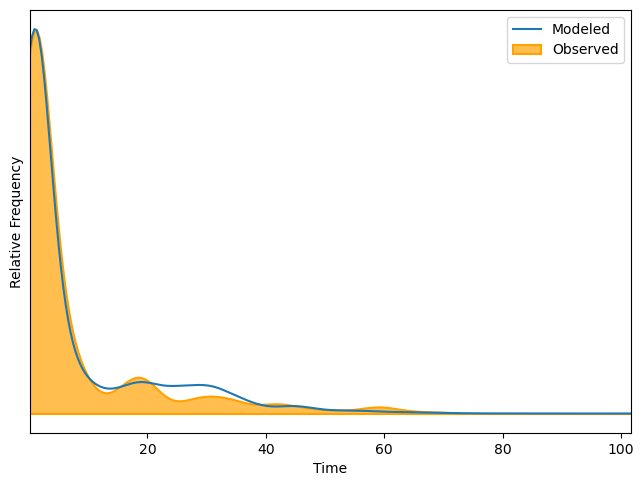

In [106]:
m.distribution_on_idca_variable('Time', style='kde',)

<Axes: xlabel='Time', ylabel='Relative Frequency'>

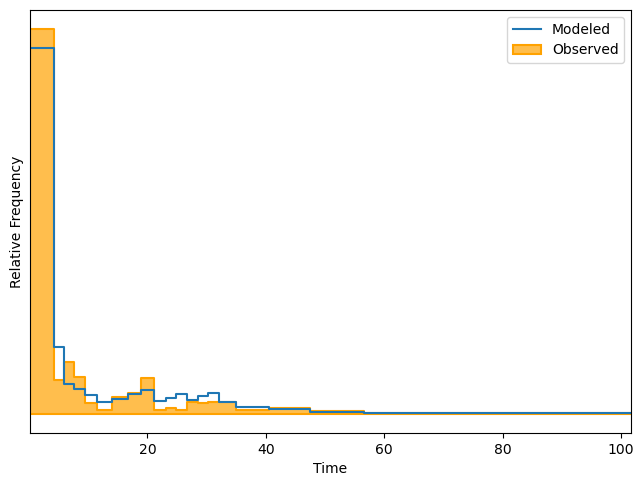

In [107]:
m.distribution_on_idca_variable('Time')

In [108]:
# Report
report = larch.Reporter(title=m.title)
report << '## Data Statistics' << m.dataframes.data_ca.statistics()
report << "## Utility Functions" << m.utility_functions()
report << '## Parameter Summary' << m.parameter_summary()
report << "## Estimation Statistics" << m.estimation_statistics()

# Add figure
#report << "## Visualization"
#report << fig

report.save(
    '.\Oahu_VisDC_' + purpose + '_NL.html',
    overwrite=True,
    metadata=m,
)

'.\\Oahu_VisDC_HBRec_NL.html'